<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_01_custom_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Custom Transformers

#### Why Use Custom Transformers?

1. **Domain-Specific Transformations**: Apply transformations that are specific to the problem domain or dataset.
2. **Reusability**: Encapsulate complex preprocessing logic in a reusable and modular way.
3. **Pipeline Integration**: Seamlessly integrate custom transformations into an sklearn pipeline for consistent and streamlined preprocessing.

#### How to Create a Custom Transformer

Custom transformers can be created by subclassing `BaseEstimator` and `TransformerMixin` from sklearn. You need to implement the `fit` and `transform` methods.

### Example: Creating and Using a Custom Transformer

Let's create a custom transformer to add a new feature to the Adult Census Income dataset: the ratio of `capital_gain` to `capital_loss`.

#### Step-by-Step Guide

1. **Define the Custom Transformer**: Create a class that inherits from `BaseEstimator` and `TransformerMixin`.
2. **Implement the `fit` Method**: This method doesn't need to do anything but must be defined.
3. **Implement the `transform` Method**: Apply the transformation to the data.
4. **Integrate the Custom Transformer into a Pipeline**: Use the custom transformer as a step in the pipeline.

### Explanation of the Code

1. **Custom Transformer (`CapitalGainLossRatio`)**: This transformer adds a new feature, the ratio of `capital_gain` to `capital_loss`.
   - **`fit` Method**: No special fitting is required, so it just returns `self`.
   - **`transform` Method**: Adds a new column `capital_gain_loss_ratio` to the dataset.
   
2. **Pipeline Integration**: The custom transformer is added as the first step in the pipeline, followed by preprocessing and logistic regression.

### Additional Custom Transformer Examples

1. **Handling Missing Data in a Specific Way**: Custom imputation strategies for certain columns.
2. **Feature Engineering**: Creating interaction terms or polynomial features.
3. **Data Cleaning**: Removing or transforming outliers, normalizing specific columns.

By leveraging custom transformers, you can tailor the preprocessing steps to fit the specific needs of your dataset and problem, ensuring that your machine learning pipeline is both flexible and powerful.

In [ ]:

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == '>50K' else 0)  # Convert target to binary

# Define the custom transformer
class CapitalGainLossRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['capital_gain_loss_ratio'] = X['capital_gain'] / (X['capital_loss'] + 1)  # Avoid division by zero
        return X

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the full pipeline with a custom transformer and a classifier
pipeline = Pipeline(steps=[
    ('capital_gain_loss_ratio', CapitalGainLossRatio()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.66      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769

Cross-validation scores:  [0.85323097 0.84926424 0.85527831 0.84873304 0.85026875]
Mean cross-validation score:  0.8513550608264019


### Custom Transformer for Interaction Terms

#### Step-by-Step Guide

1. **Define the Custom Transformer**: Create a class that inherits from `BaseEstimator` and `TransformerMixin`.
2. **Implement the `fit` Method**: This method doesn't need to do anything but must be defined.
3. **Implement the `transform` Method**: Apply the transformation to generate interaction terms.
4. **Integrate the Custom Transformer into a Pipeline**: Use the custom transformer as a step in the pipeline.

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == '>50K' else 0)  # Convert target to binary

# Define the custom transformer for interaction terms
class InteractionTerms(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for feature1, feature2 in self.features:
            interaction_term = f"{feature1}_x_{feature2}"
            X[interaction_term] = X[feature1] * X[feature2]
        return X

# Specify features for interaction terms
interaction_features = [('capital_gain', 'capital_loss'), ('age', 'hours_per_week')]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the full pipeline with a custom transformer and a classifier
pipeline = Pipeline(steps=[
    ('interaction_terms', InteractionTerms(features=interaction_features)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.66      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769

Cross-validation scores:  [0.85323097 0.84926424 0.85527831 0.84873304 0.85026875]
Mean cross-validation score:  0.8513550608264019


#### Plot Numeric Data

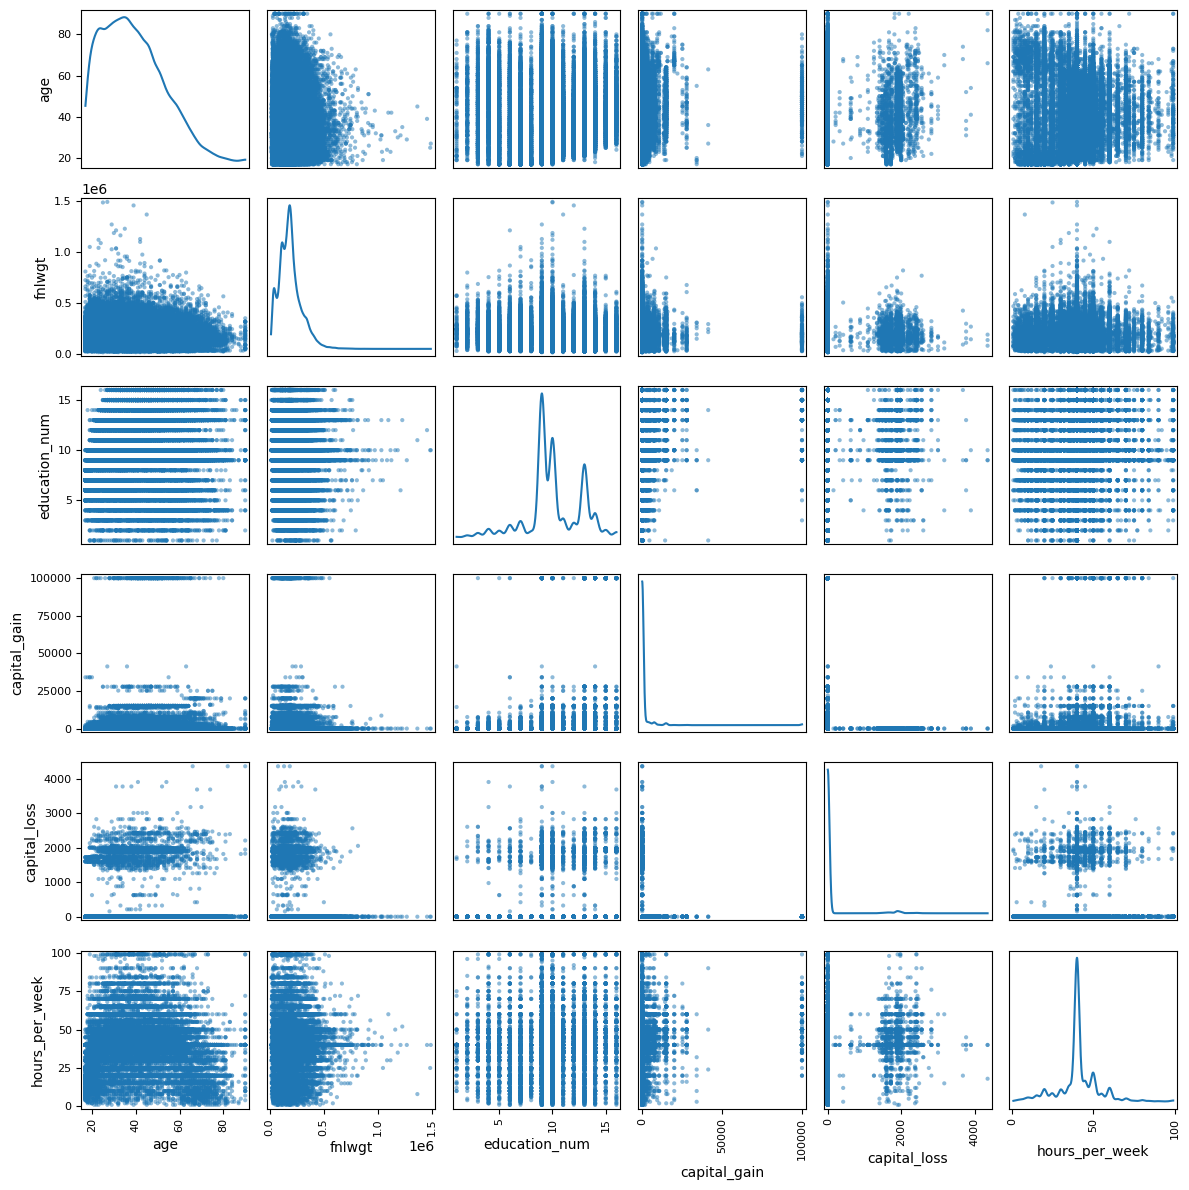

In [ ]:
import matplotlib.pyplot as plt

scatter_matrix = pd.plotting.scatter_matrix(df[numeric_features], figsize=(12, 12), diagonal='kde')
plt.tight_layout()
plt.show()

### Custom Combined Transformer

1. **Define the Custom Transformers**:
   - Interaction terms transformer.
   - Log transformation transformer.
2. **Combine the Custom Transformers into a Pipeline**:
   - Create a pipeline that applies the log transformation and interaction terms, followed by standard preprocessing and classification.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == '>50K' else 0)  # Convert target to binary

# Define the custom transformer for interaction terms
class InteractionTerms(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for feature1, feature2 in self.features:
            interaction_term = f"{feature1}_x_{feature2}"
            X[interaction_term] = X[feature1] * X[feature2]
        return X

# Define the custom transformer for log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.features:
            X[f'log_{feature}'] = np.log1p(X[feature])  # Use log1p to avoid issues with zero values
        return X

# Specify features for interaction terms and log transformation
interaction_features = [('capital_gain', 'capital_loss'), ('age', 'hours_per_week')]
log_features = ['capital_loss', 'capital_gain', 'fnlwgt']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the full pipeline with custom transformers and a classifier
pipeline = Pipeline(steps=[
    ('log_transform', LogTransformer(features=log_features)),
    ('interaction_terms', InteractionTerms(features=interaction_features)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.66      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769

Cross-validation scores:  [0.85323097 0.84926424 0.85527831 0.84873304 0.85026875]
Mean cross-validation score:  0.8513550608264019
